# Find Polar Contacts

In [3]:
from biopandas.pdb import PandasPdb
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

In [77]:
def find_polar_contacts(pdb_path: str, chain1: str, chain2: str, cutoff=3.5):
    """
    Find polar contacts between two input chains in a PDB file using BioPandas.
    
    Parameters:
    pdb_path (str): Path to the PDB file.
    chain1 (str): Identifier for the first chain.
    chain2 (str): Identifier for the second chain.
    cutoff (float): Distance cutoff for identifying polar contacts.
    
    Returns:
    dict: A dictionary with chain identifiers as keys and lists of residue numbers involved in polar contacts as values.
    """
    ## Load PDB file
    ppdb = PandasPdb().read_pdb(pdb_path)
    df = ppdb.df['ATOM']

    ## Select polar atoms (N, O) from each chain
    polar_atoms_chain1 = df[(df['chain_id'] == chain1) & (df['element_symbol'].isin(['N', 'O']))]
    polar_atoms_chain2 = df[(df['chain_id'] == chain2) & (df['element_symbol'].isin(['N', 'O']))]

    ## Calculate pairwise distances between polar atoms
    distances = cdist(polar_atoms_chain1[['x_coord', 'y_coord', 'z_coord']].values, 
                      polar_atoms_chain2[['x_coord', 'y_coord', 'z_coord']].values)

    ## Find pairs of atoms within the distance cutoff
    pairs = np.argwhere(distances <= cutoff)

    ## Find corresponding residue numbers and names
    residue_numbers_chain1 = polar_atoms_chain1['residue_number'].values
    residue_numbers_chain2 = polar_atoms_chain2['residue_number'].values

    residue_names_chain1 = polar_atoms_chain1['residue_name'].values
    residue_names_chain2 = polar_atoms_chain2['residue_name'].values

    polar_contact_residues = []
    for pair in pairs:
        polar_contact_residues.append([
            residue_names_chain1[pair[0]],
            residue_numbers_chain1[pair[0]],
            residue_names_chain2[pair[1]],
            residue_numbers_chain2[pair[1]]
            ])

    ## Make polar contact residues a set
    polar_contact_residues = set(map(tuple, polar_contact_residues))

    ## Assemble dictionary
    polar_contact_residues_dict = {
        f"resn_chain{chain1}": [],
        f"resi_chain{chain1}": [],
        f"resn_chain{chain2}": [],
        f"resi_chain{chain2}": []
        }
    
    for pair in polar_contact_residues:
        polar_contact_residues_dict[f"resn_chain{chain1}"].append(pair[0])
        polar_contact_residues_dict[f"resi_chain{chain1}"].append(pair[1])
        polar_contact_residues_dict[f"resn_chain{chain2}"].append(pair[2])
        polar_contact_residues_dict[f"resi_chain{chain2}"].append(pair[3])

    ## Convert to dataframe
    polar_contact_residues_df = pd.DataFrame(polar_contact_residues_dict)

    return polar_contact_residues_df

In [130]:
pdb_path = "/Users/colbyford/Downloads/mdscoring_1.pdb"
chain1 = "A"
chain2 = "B"
cutoff = 3


contacts = find_polar_contacts(pdb_path, chain1, chain2, cutoff)
contacts

,resn_chainA,resi_chainA,resn_chainB,resi_chainB
0,THR,104,LYS,196
1,TYR,1093,ASP,190
2,THR,104,GLU,193
3,THR,104,GLY,228
4,SER,1034,LYS,225
5,TYR,1033,ASN,189
6,THR,103,SER,140
7,SER,1053,ASN,227
8,GLY,32,SER,135
9,TYR,1093,GLU,193


In [131]:
## Make blank dataframe of positions from resi_start to resi_end
resi_start = 111
resi_end = 269

residue_numbers = [f"pos_{i}" for i in range(resi_start, resi_end+1)]

In [132]:
## Make dataframe
positions = pd.DataFrame(columns=["pdb_path"] + residue_numbers)

## fill with zeros
positions.loc[0] = 0

## fill with ones where there was a contact
for pos in set(contacts["resi_chainB"].tolist()):
    positions.loc[0, f"pos_{pos}"] = 1

positions.loc[0, "pdb_path"] = pdb_path

positions

/var/folders/z3/v28jyh8n5js19358f_3pkwkh0000gn/T/ipykernel_28307/999115397.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '/Users/colbyford/Downloads/mdscoring_1.pdb' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  positions.loc[0, "pdb_path"] = pdb_path


,pdb_path,pos_111,pos_112,pos_113,pos_114,pos_115,pos_116,pos_117,pos_118,pos_119,...,pos_260,pos_261,pos_262,pos_263,pos_264,pos_265,pos_266,pos_267,pos_268,pos_269
0,/Users/colbyford/Downloads/mdscoring_1.pdb,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


-----------------
## PyMOL Highlighter

In [133]:
from pymol import cmd

In [134]:
cmd.reinitialize("everything")
cmd.load(pdb_path)

## Color chain A grey50
cmd.color("grey50", f"chain {chain1}")

## color chain B green
cmd.color("green", f"chain {chain2}")

1

In [135]:
def highlight_residues(chain:str="A", residues:list=[], style:str="sticks", color:str="red"):
    """
    Highlight residues in a chain in a given style and color.

    Parameters:
    chain (str): Chain identifier.
    residues (list): List of residue numbers.
    style (str): Style to use for highlighting.
    color (str): Color to use for highlighting.
    """
    ## Generate a selection string for the residues
    selection = " or ".join([f"(chain {chain} and resi {res})" for res in residues])
    selection_name = f"highlight_{chain}"
    ## Create the selection in PyMOL
    cmd.select(selection_name, selection)
    ## Show the selection as sticks
    cmd.show(style, selection_name)
    ## Color the selection red
    cmd.color(color, selection_name)


In [136]:
print("Chain A: ", list(set(contacts["resi_chainA"].tolist())), "\n",
      "Chain B: ", list(set(contacts["resi_chainB"].tolist())))

Chain A:  [32, 34, 1093, 102, 103, 104, 1033, 1034, 1036, 27, 1053] 
 Chain B:  [193, 225, 227, 196, 228, 229, 135, 140, 146, 147, 189, 190]


In [137]:
## Highlight Chain A
highlight_residues(chain = "A",
                   residues = list(set(contacts["resi_chainA"].tolist())),
                   color = "grey50")

## Highlight Chain B
highlight_residues(chain = "B",
                   residues = list(set(contacts["resi_chainB"].tolist())),
                   color = "red")

In [138]:
## Initialize temp file for rendering
import tempfile

tmp_png = tempfile.NamedTemporaryFile(delete=False, prefix=f"temp_", suffix=".png")
print(tmp_png.name)

/var/folders/z3/v28jyh8n5js19358f_3pkwkh0000gn/T/temp_12w8syq6.png


In [139]:
cmd.orient()
# cmd.do("ray")
cmd.png(tmp_png.name, width=1920, height=1080, ray=1)

1

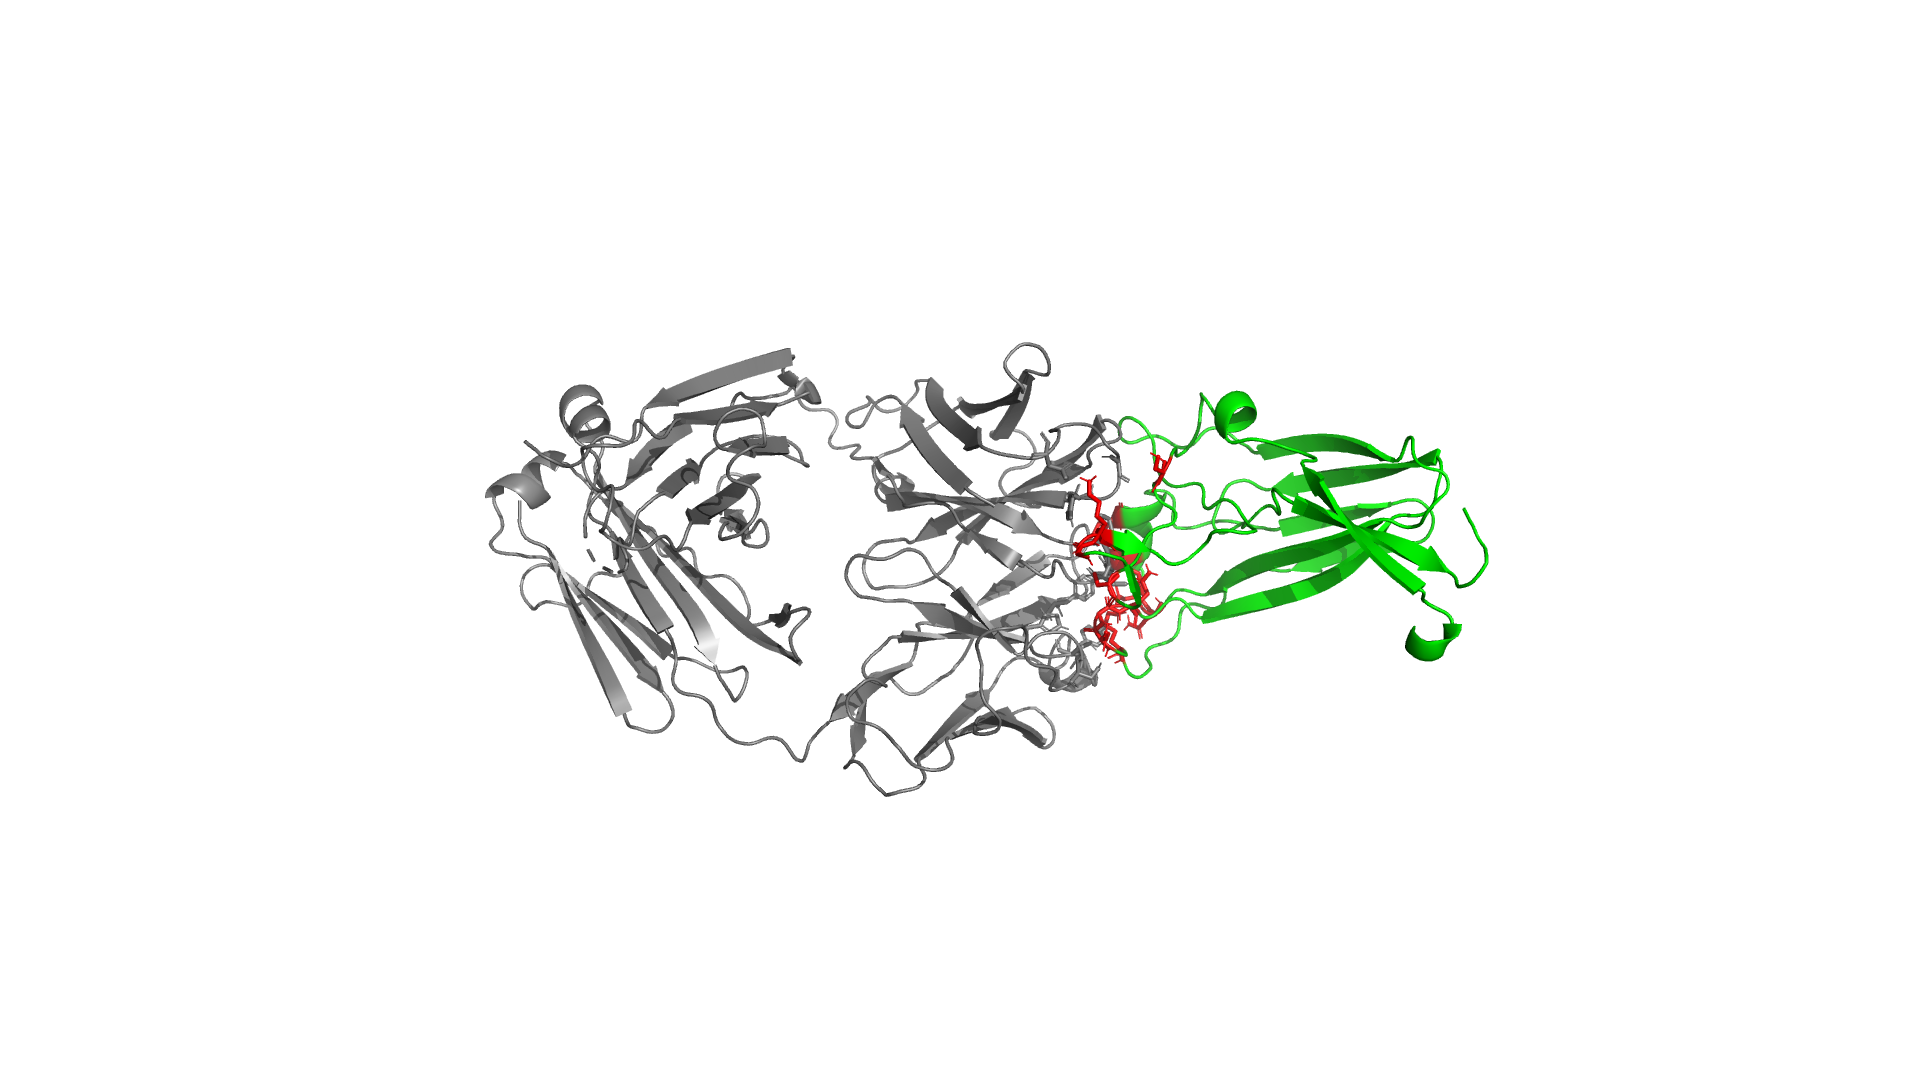

In [140]:
from IPython.display import Image
Image(tmp_png.name)